# Bridge over troubled water

The data journalism website [FiveThirtyEight](https://fivethirtyeight.com) has a weekly column that presents a problem connected to math, logic and/or probability. A while ago they posted a [problem](https://fivethirtyeight.com/features/night-falls-a-storm-rolls-in-can-you-cross-the-river/), that I really enjoyed because it has a surprisingly simple solution (which I missed completely). I therefore thought I would share it here

## The problem
You’re on the north shore of a river, and want to cross to the south, via a series of 13 bridges and six islands, which you can see in the diagram below. But, as you approach the water, night falls, a bad storm rolls in, and you’re forced to wait until morning to try to cross. Overnight, the storm could render some of the bridges unusable — it has a 50 percent chance of knocking out each of the bridges. (The chance is independent for each bridge.)

<figure align="middle">
  <img src="./images/bridge1.png" title="Bridge over troubled water" width=600>
  <figcaption>Illustration from FiveThirtyEight</figcaption>
</figure>

Question 1: What’s the probability you will be able to cross the river in the morning? (You have no boat, can’t swim, can’t fix the bridges, etc. No tricks.)

Now imagine a different, wider river, with many more islands — in fact, arbitrarily many. Specifically, imagine that the islands are arrayed in an N-rows-by-N+1-columns grid — similar to before, where N happened to equal two — and connected by bridges to each adjacent island in the same way. Each island adjacent to the shore is also connected by a bridge to the shore. It would look something like this:

<figure align="middle">
  <img src="images/bridge2.png" title="Bridge over troubled water" width=600>
  <figcaption>Illustration from FiveThirtyEight</figcaption>
</figure>

Question 2: What’s the probability you’ll be able to cross this river in the morning, after the same storm — with the same independent 50 percent chance of knocking out each bridge — rolls through?

## Brute-force solution

Let us start by considering how many possible configurations there are of the system of bridges. From the geometry of the problem one can quickly realise that the total number of bridges for a particular value of $N$ is

$$N_\mathrm{bridge} = N^2 + (N+1)^2.$$

Each bridge has two possible states: it stays or it is knocked out. Therefore the number of different configurations for the system of bridges are

$$N_\mathrm{configuration} = 2^{N_\mathrm{bridge}}.$$

Thus, for $N=2$, $N_\mathrm{bridge} = 13$ and $N_\mathrm{configuration} = 8192$. Because the probability of each bridge being knocked out is exactly 50 percent all possible configurations are equally likely.

A brute-force solution to the problem is to simply iterate over all possible configurations and count those where the river can still be crossed.

### Brute-force setup
I will use the python package `networkx` to create an undirected graph to represent the layout of the problem.

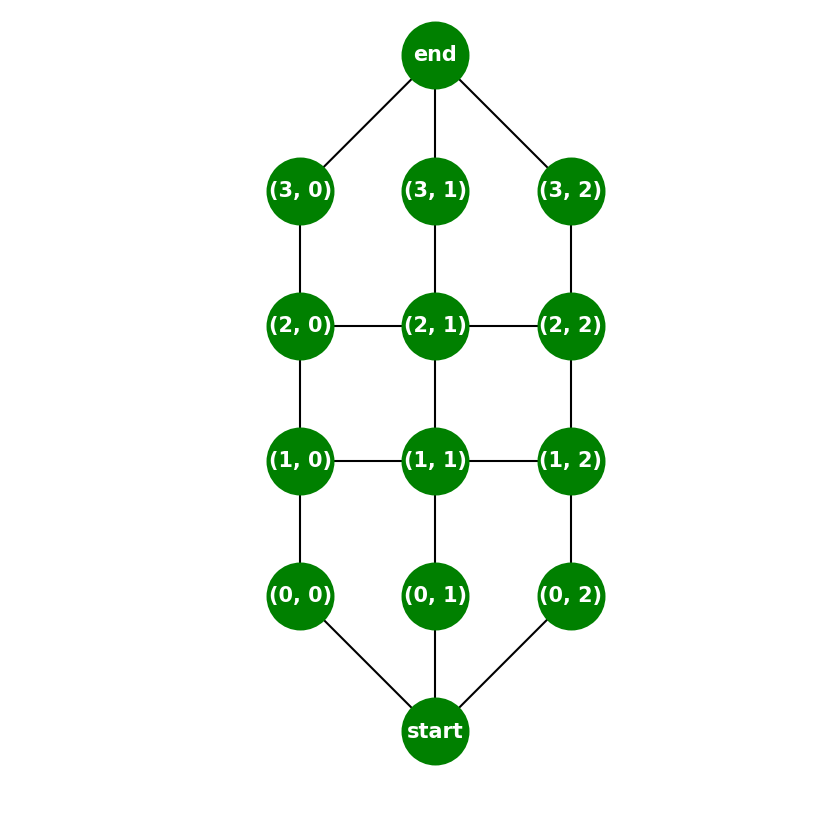

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as mp

def generate_bridge_layout(n):
    """Generate undirected graph for bridge layout"""

    graph = nx.Graph()

    m = n+1

    for i in range(n+2):
        for j in range(n+1):
            if i < n+1:
                # vertical bridges
                graph.add_edge((i, j), (i+1, j))
            if j < n and i > 0 and i < n+1:
                # horizontal bridges
                graph.add_edge((i, j), (i, j+1))
            if i == 0:
                # paths between start node and south riverbank nodes
                graph.add_edge('start', (0, j))
            if i == n+1:
                # paths between north riverbank nodes and end node
                graph.add_edge((n+1, j), 'end')

    return graph

def draw_bridge_layout(graph, n):
    """draw bridge layout"""

    pos = dict()
    for node in graph.nodes:
        if node == 'start':
            pos[node] = [n/2, -1]
        elif node == 'end':
            pos[node] = [n/2, n+2]
        else:
            pos[node] = list(node)[::-1]

    nx.draw(graph, pos, with_labels=True, node_size=1000, node_color='g', font_size=10, 
            font_color='w', font_weight='bold')
    mp.axis('equal')

bridge_layout_2 = generate_bridge_layout(2)

fig = mp.figure(figsize=(5, 5), dpi=150)
draw_bridge_layout(bridge_layout_2, 2)

The plot shows the undirected graph representing the $N=2$ case, with two special nodes (start and end) added so that the path finding problem starts and terminates at fixed nodes. The labels on the remaining nodes represent their coordinate positions with the origin at the lower left node.

### Solving the problem
The problem can be solved by iterating over all possible bridge configurations, and checking if there is a path between the start and end nodes.

The function below generates all possible configurations of the problem and checks whether there is a path from the start to the end node. The function uses the `has_path` function, that is part of the `networkx` package.

In [2]:
from itertools import combinations
import pandas as pd

def nbridge(n):
    return n**2 + (n+1)**2

def generate_solutions(graph):
    # get list of bridges
    edges = []
    for edge in graph.edges:
        if edge[0] in ['start', 'end'] or edge[1] in ['start', 'end']:
            continue
        edges.append(edge)

    n_bridges = len(edges)

    solutions = []
    for n_bridges_removed in range(0, n_bridges+1):
        # loop over all combinations bridges with n_bridges_removed removed
        for bridges_removed in combinations(edges, n_bridges_removed):
            graph.remove_edges_from(bridges_removed) # remove the bridges
            result = nx.has_path(graph, 'start', 'end') # check if a path exists
            graph.add_edges_from(bridges_removed) # reinsert the bridges

            #append solution
            solutions.append(dict(path=result, n_bridges_removed=n_bridges_removed))

    return pd.DataFrame(solutions)

bridge_solution_2 = generate_solutions(bridge_layout_2)
n_clear_path_2 = bridge_solution_2.path.sum()

print("N = 2 case")
print("Number of bridges = {}".format(nbridge(2)))
print("Number of possible configurations = {}".format(2**nbridge(2)))
print("Number of configurations with clear path = {}".format(n_clear_path_2))
print("Probability of crossing river = {:.2%}".format(n_clear_path_2/2**nbridge(2)))

N = 2 case
Number of bridges = 13
Number of possible configurations = 8192
Number of configurations with clear path = 4096
Probability of crossing river = 50.00%


It is possible to cross the river for exactly 50 percent of the configurations, and we thus have our answer to question 1.

To answer question 2 let's check the probability for the $N=1$ and $N=3$ cases.

In [3]:
bridge_layout_1 = generate_bridge_layout(1)
bridge_solution_1 = generate_solutions(bridge_layout_1)
n_clear_path_1 = bridge_solution_1.path.sum()

print("N = 1 case")
print("Number of bridges = {}".format(nbridge(1)))
print("Number of possible configurations = {}".format(2**nbridge(1)))
print("Number of configurations with clear path = {}".format(n_clear_path_1))
print("Probability of crossing river = {:.2%}".format(n_clear_path_1/2**nbridge(1)))

bridge_layout_3 = generate_bridge_layout(3)
bridge_solution_3 = generate_solutions(bridge_layout_3)
n_clear_path_3 = bridge_solution_3.path.sum()

print(" ")
print("N = 3 case")
print("Number of bridges = {}".format(nbridge(3)))
print("Number of possible configurations = {}".format(2**nbridge(3)))
print("Number of configurations with clear path = {}".format(n_clear_path_3))
print("Probability of crossing river = {:.2%}".format(n_clear_path_3/2**nbridge(3)))

N = 1 case
Number of bridges = 5
Number of possible configurations = 32
Number of configurations with clear path = 16
Probability of crossing river = 50.00%
 
N = 3 case
Number of bridges = 25
Number of possible configurations = 33554432
Number of configurations with clear path = 16777216
Probability of crossing river = 50.00%


For $N=1$, $N=2$, and $N=3$, the probability of being able to cross the river is exactly 50 percent. It would thus appear that the probability is always 50 percent nomatter the value of $N$. Unforuntately, with $33554432$ possible configurations, $N=3$ is the largest case that can be comfortably solved with a brute-force approach. To get a definite answer to question 2, we therefore have to dwelve deeper into the problem.

## Elegant solution

The more elegant solution does not really require much math. Imagine you are a ship sailing up the river past the group of islands from east to west. The mast of your ship is too tall to pass under a bridge so you can only cross through if the bridge has been knocked out. Notice that the geometry of the problem (regardless of the value of $N$) for the ship sailing up the river is identical to the setup for the person trying to cross the river via the bridges. Since each bridge has a 50/50 chance of being knocked out, the two problems are completely identical. This means that the probability of the ship being able to sail past the group of islands, and you being able to cross the river must be the same.

<figure align="middle">
  <img src="images/bridge3.png" title="Bridge over troubled water" width=600>
  <figcaption>Illustration from FiveThirtyEight</figcaption>
</figure>

Finally, we notice that if you can cross the bridge by foot it will be impossible for the ship to sail past the islands and vice versa (the two problems are mutually exclusive). Therefore each have a 50% chance of achieving their goal, which also gives us the answer to question 2.

## Bonus: Varying the probability of bridge being knocked out
The analysis above is only valid if the probability of the bridge being knocked out is exactly 50 percent. What happens if the probability of each bridge being knocked out varies?

Let $p$ be the probability that a bridge is not knocked out. Since $p$ is no longer assumed to be $0.5$ the probability of all configurations are no longer equal. The probability of a given configuration occuring is

$$p^{N_\mathrm{bridge} - N_\mathrm{gone}} \times (1-p)^{N_\mathrm{gone}}$$

where $N_\mathrm{gone}$ is the number of bridges that have been knocked out. The probability of crossing the river is the sum of the probabilities of the configurations, where there is a path across the river.

Text(0,0.5,'Probability of crossing river')

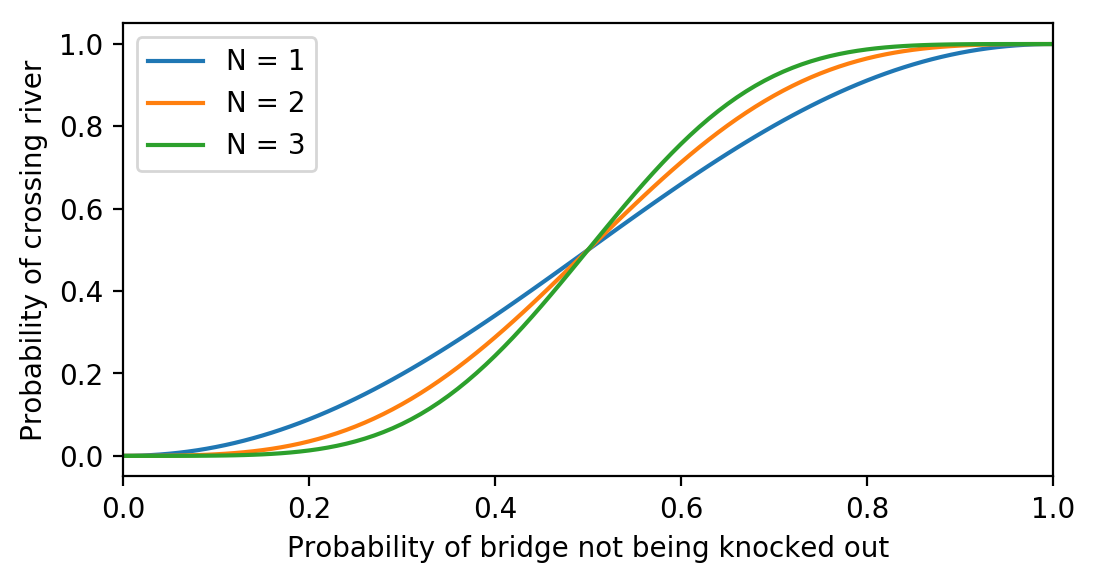

In [14]:
import numpy as np

def crossing_probability(probabilities, n, df):
    """probability of crossing the river where p is probability of bridge staying"""
    n_bridge = nbridge(n)

    df_temp = df[df['path']]

    f = lambda x, y: np.sum(y**(n_bridge - x) * (1-y)**x)

    bridge_crossing_probabilities = np.empty(probabilities.size, dtype=np.float64)
    for i, p in enumerate(probabilities):
        bridge_crossing_probabilities[i] = f(df_temp.n_bridges_removed, p)

    return bridge_crossing_probabilities

prob = np.linspace(0, 1, 101)

fig = mp.figure(figsize=(6, 3), dpi=200)
for n, solution in zip([1, 2, 3], [bridge_solution_1, bridge_solution_2, bridge_solution_3]):
    cross_prob = crossing_probability(prob, n, solution)
    mp.plot(prob, cross_prob, label="N = {}".format(n))
mp.legend()
mp.xlim(0, 1)
mp.xlabel("Probability of bridge not being knocked out")
mp.ylabel("Probability of crossing river")

The plot shows how the probability of crossing the river changes for three values of $N$.